### Applied Time Series Analysis - Lab 1 
Peter Woo

March 3, 2021



##Summary

This paper aims to explore whether natural disasters around the globe, measured by People Affected by Natural Disasters (PAD), is related to the El Nino Southern Oscillation, measured by Multivariate ENSO index (MEI) and the Oceanic Nino Index (ONI). They did this by analyzing three disaster types and three regions using data from an emergency events database (EM-DAT) and applying time series regression techniques to characterize its annual relationships between ONI and MEI. They concluded that to some degree, ENSO is correlated with “climate-related hazards” and “health burdens.” With this information, they believe they can flag countries that they found to be more at risk during El Nino events given that El Nino events have been accurately predicted in the past. By doing this they may be able to aid countries in need in forecasting natural disasters and minimizing the potential damage. 


## Reproducing figure 1 from the paper


### ONI Data

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘signal’, ‘PolynomF’, ‘waveslim’, ‘astsa’




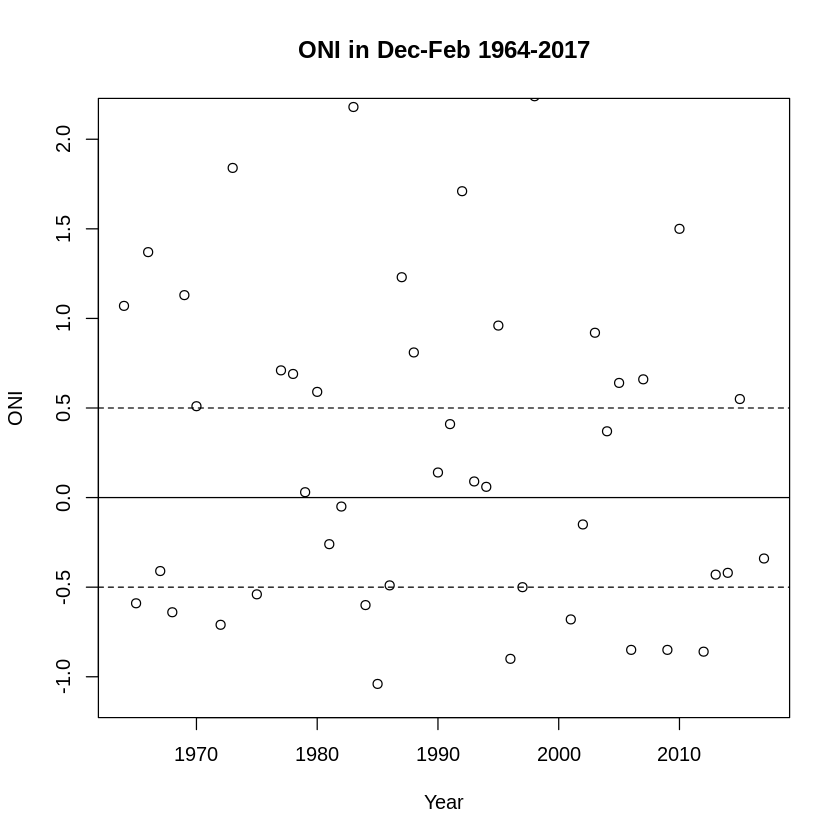

In [1]:
# Import the necessary packages
install.packages('tswge')
library('tswge')
# Download the data
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')
# Turn the data into a dataframe
oni.df <- read.table(oni.file, header = TRUE)
# Subset the data to find the values in figure 1 of the paper
target_oni.df <- oni.df[which((oni.df$YR < 2018) & (1963 < oni.df$YR) & (oni.df$SEAS == 'DJF')), names(oni.df) %in% c('YR', 'ANOM') ]
# Make the plot
plot(
    target_oni.df,
    main = "ONI in Dec-Feb 1964-2017",
    ylim = c(-1.1, 2.1),
    type = 'p',
    xlab = 'Year',
    ylab = 'ONI'
)
# Add in the horizontal lines
abline(h=0.0)
abline(h=0.5, lty = 2)
abline(h=-0.5, lty = 2)


### MEI Data

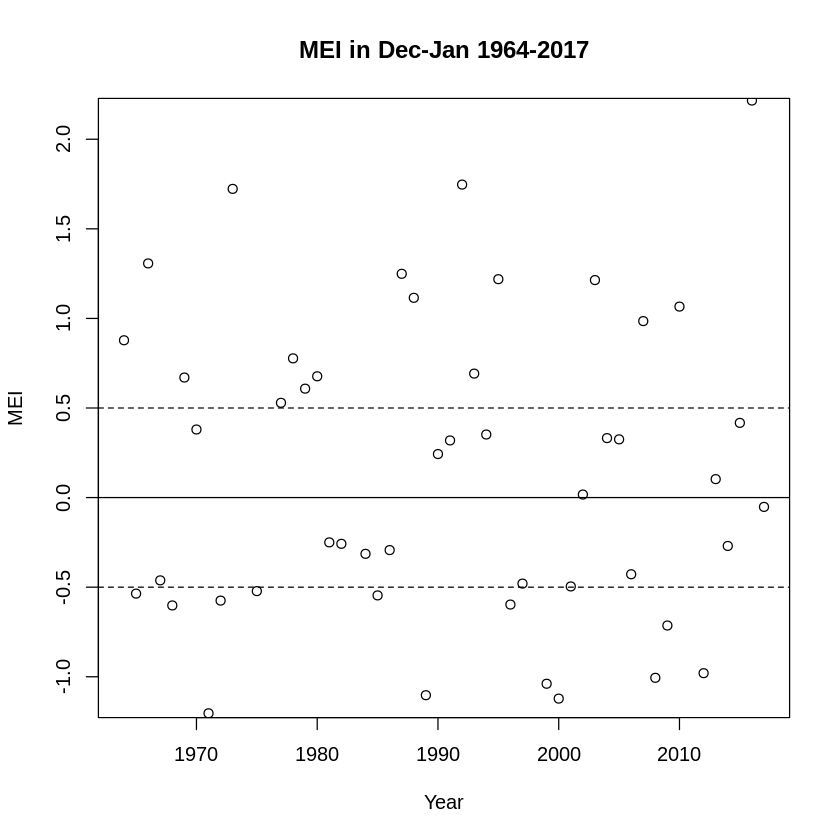

In [2]:
# Download the data
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')
# Turn the data into a dataframe
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^[0-9].*", my.line)
  if (length(a) > 0) {
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols) {
      my.values <- c()
      for (d in my.data) {
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = my.values
    }
  }
}
# Subset the data to reproduce the plot from the paper
target_mei.df <- mei.df[which((mei.df$YEAR < 2018) & (1963 < mei.df$YEAR)), names(mei.df) %in% c('YEAR', 'DECJAN')]
# Create the plot
plot(
    target_mei.df,
    main = "MEI in Dec-Jan 1964-2017",
    ylim = c(-1.1, 2.1),
    type = 'p',
    xlab = 'Year',
    ylab = 'MEI'
)
# Add in the horizontal lines
abline(h=0.0)
abline(h=0.5, lty = 2)
abline(h=-0.5, lty = 2)

### PAD Data

In [3]:
# Import the PAD data from local tmp file
pad.file <- "/tmp/emdat_public.csv"
pad.df.all <- read.csv(pad.file, header=TRUE, skip=6)
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Affected")
# Create a dataframe
pad.df <- pad.df.all[cols.interest]

In [4]:
# Import the worldbank dataframe to match with the PAD dataset
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)
unzip(zipfile = wbank.file, exdir = "/tmp")
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}
print(my.file)
wb.file <- paste("/tmp/", my.file, sep="")
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)
length(unique(wb.df$Country.Code))
for (i in 1:nrow(pad.df)) {
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start.Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  a <- match(tmp.iso, wb.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- wb.df[,tmp.col][a]
    pad.df[i, 'POP'] = tmp.pop
  } else {
    pad.df[i, 'POP'] = NA
  }
}

In [5]:
# Create a loop to calculate PAD per 1000
final_pad.vect <- character()
for (years in unique(pad.df$Start.Year)) {
  my.tmp.pad <- subset(pad.df, Start.Year == years)
  pad.tmp <- 0
  for (i in 1:nrow(my.tmp.pad)){
    if (!is.na(my.tmp.pad$Total.Affected[i]) & !is.na(my.tmp.pad$POP[i])){
      my.ta <- my.tmp.pad$Total.Affected[i]
      pad.tmp <- pad.tmp + my.ta
    }
  }
  pop.tmp <- 0
  for (my.iso in unique(my.tmp.pad$ISO)){
    a <- match(my.iso, my.tmp.pad$ISO)
    temp.pop <- my.tmp.pad$POP[a]
    if (!is.na(temp.pop)){
      pop.tmp <- pop.tmp + temp.pop
    }
  }
  fin_pad <- pad.tmp/pop.tmp*1000
  final_pad.vect <- c(final_pad.vect, fin_pad)
# Join the vector of PAD per 1000 values with years
yrs <- c(1964:2017)
final_pad.df <- data.frame(as.numeric(yrs), final_pad.vect)
# Create the plot
plot(
    final_pad.df,
    main = "PAD (per 1000) 1964-2017",
    ylim = c(0, 170),
    type = 'p',
    xlab = 'Year',
    ylab = 'PAD'
)

ERROR: ignored

## Correct/Process data into time series, investigate data


### ONI Data

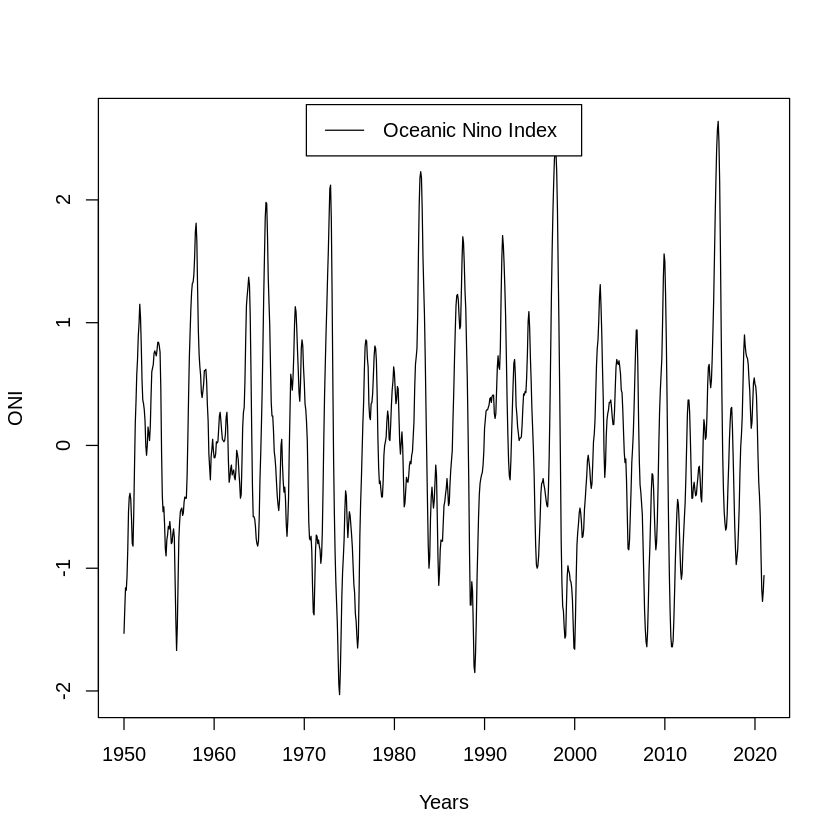

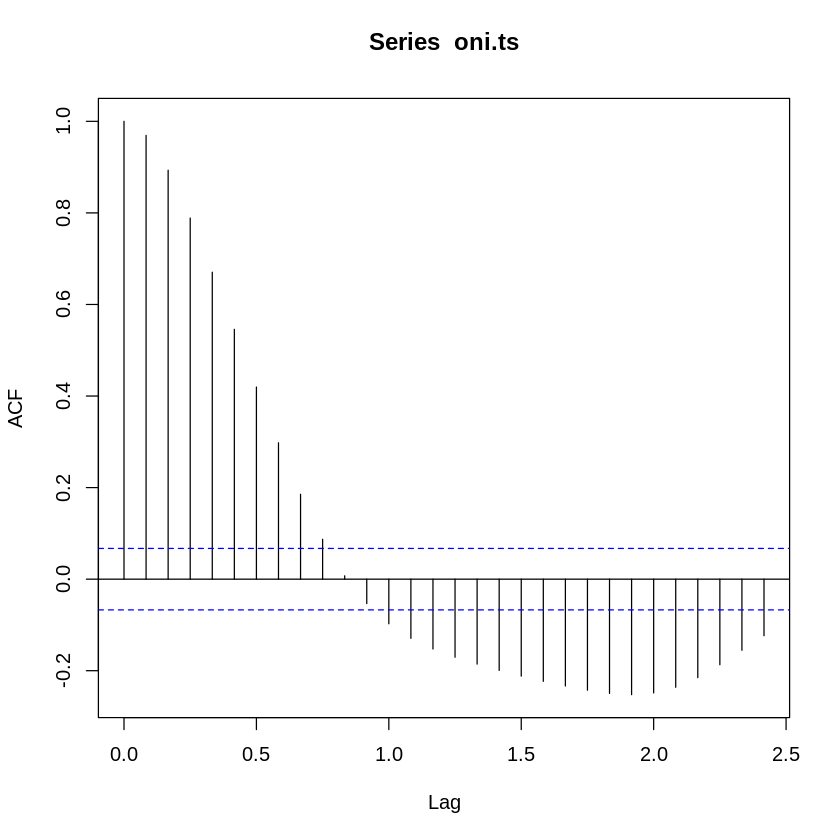

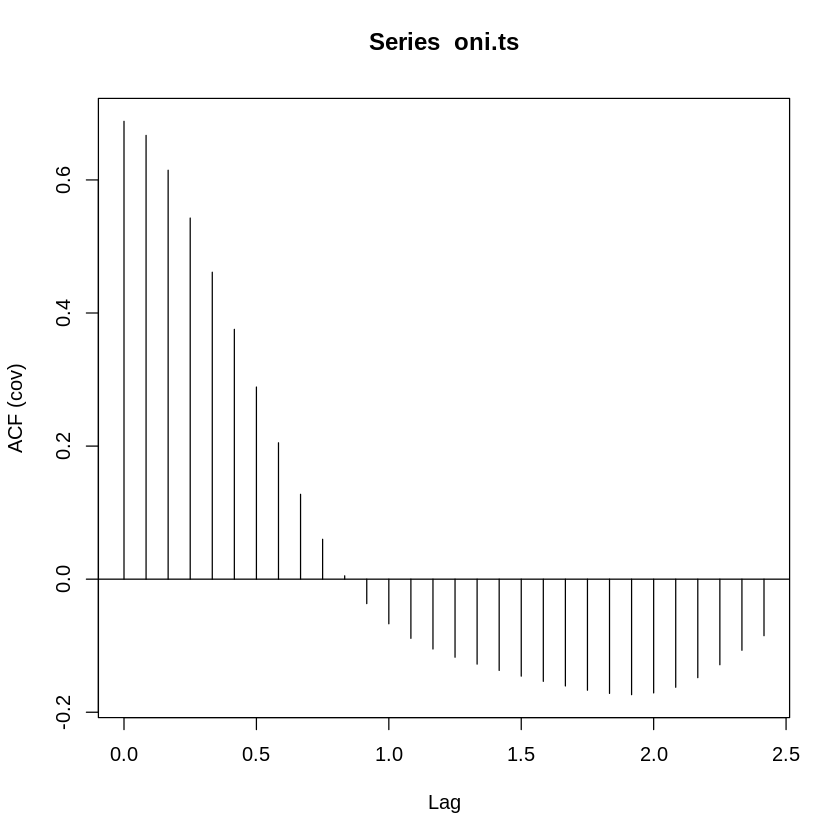

In [6]:
# Turn the data into a time series
oni.ts <- ts(oni.df$ANOM, start = c(1950, 1), frequency = 12) 
# Create the plot and add a legend
plot(oni.ts, type = 'l', xlab = 'Years', ylab = 'ONI',)
legend("top", inset = 0.01, lty = 1, lwd = 1, legend = 'Oceanic Nino Index')
# Calculate the autocorrelation and autocovariance
acf(oni.ts, type= 'correlation', plot = TRUE)
acf(oni.ts, type= 'covariance', plot = TRUE)

$autplt
 [1]  1.000000000  0.969250049  0.893164902  0.788715500  0.670390835
 [6]  0.545613787  0.419619680  0.297851134  0.185314209  0.087088468
[11]  0.007245828 -0.053376674 -0.097443665 -0.129223489 -0.152513673
[16] -0.170495734 -0.185531013 -0.199291500 -0.211796066 -0.223153052
[21] -0.233272811 -0.242546922 -0.249488279 -0.252295878 -0.248439097
[26] -0.236096404

$freq
  [1] 0.001172333 0.002344666 0.003516999 0.004689332 0.005861665 0.007033998
  [7] 0.008206331 0.009378664 0.010550996 0.011723329 0.012895662 0.014067995
 [13] 0.015240328 0.016412661 0.017584994 0.018757327 0.019929660 0.021101993
 [19] 0.022274326 0.023446659 0.024618992 0.025791325 0.026963658 0.028135991
 [25] 0.029308324 0.030480657 0.031652989 0.032825322 0.033997655 0.035169988
 [31] 0.036342321 0.037514654 0.038686987 0.039859320 0.041031653 0.042203986
 [37] 0.043376319 0.044548652 0.045720985 0.046893318 0.048065651 0.049237984
 [43] 0.050410317 0.051582649 0.052754982 0.053927315 0.055099648 0.056271981
 [49] 0.057444314 0.058616647 0.059788980 0.060961313 0.062133646 0.063305979
 [55] 0.064478312 0.065650645 0.066822978 0.067995311 0.069167644 0.070339977
 [61] 0.071512309 0.072684642 0.073856975 0.075029308 0.076201641 0.077373974
 [67] 0.078546307 0.079718640 0.080890973 0.082063306 0.083235639 0.084407972
 [73] 0.085580305 0.086752638 0.087924971 0.089097304 0.090269637 0.091441970
 [79] 0.092614302 0.093786635 0.094958968 0.096131301 0.097303634 0.098475967
 [85] 0.099648300 0.100820633 0.101992966 0.103165299 0.104337632 0.105509965
 [91] 0.106682298 0.107854631 0.109026964 0.110199297 0.111371630 0.112543962
 [97] 0.113716295 0.114888628 0.116060961 0.117233294 0.118405627 0.119577960
[103] 0.120750293 0.121922626 0.123094959 0.124267292 0.125439625 0.126611958
[109] 0.127784291 0.128956624 0.130128957 0.131301290 0.132473623 0.133645955
[115] 0.134818288 0.135990621 0.137162954 0.138335287 0.139507620 0.140679953
[121] 0.141852286 0.143024619 0.144196952 0.145369285 0.146541618 0.147713951
[127] 0.148886284 0.150058617 0.151230950 0.152403283 0.153575615 0.154747948
[133] 0.155920281 0.157092614 0.158264947 0.159437280 0.160609613 0.161781946
[139] 0.162954279 0.164126612 0.165298945 0.166471278 0.167643611 0.168815944
[145] 0.169988277 0.171160610 0.172332943 0.173505275 0.174677608 0.175849941
[151] 0.177022274 0.178194607 0.179366940 0.180539273 0.181711606 0.182883939
[157] 0.184056272 0.185228605 0.186400938 0.187573271 0.188745604 0.189917937
[163] 0.191090270 0.192262603 0.193434936 0.194607268 0.195779601 0.196951934
[169] 0.198124267 0.199296600 0.200468933 0.201641266 0.202813599 0.203985932
[175] 0.205158265 0.206330598 0.207502931 0.208675264 0.209847597 0.211019930
[181] 0.212192263 0.213364596 0.214536928 0.215709261 0.216881594 0.218053927
[187] 0.219226260 0.220398593 0.221570926 0.222743259 0.223915592 0.225087925
[193] 0.226260258 0.227432591 0.228604924 0.229777257 0.230949590 0.232121923
[199] 0.233294256 0.234466589 0.235638921 0.236811254 0.237983587 0.239155920
[205] 0.240328253 0.241500586 0.242672919 0.243845252 0.245017585 0.246189918
[211] 0.247362251 0.248534584 0.249706917 0.250879250 0.252051583 0.253223916
[217] 0.254396249 0.255568581 0.256740914 0.257913247 0.259085580 0.260257913
[223] 0.261430246 0.262602579 0.263774912 0.264947245 0.266119578 0.267291911
[229] 0.268464244 0.269636577 0.270808910 0.271981243 0.273153576 0.274325909
[235] 0.275498242 0.276670574 0.277842907 0.279015240 0.280187573 0.281359906
[241] 0.282532239 0.283704572 0.284876905 0.286049238 0.287221571 0.288393904
[247] 0.289566237 0.290738570 0.291910903 0.293083236 0.294255569 0.295427902
[253] 0.296600234 0.297772567 0.298944900 0.300117233 0.301289566 0.302461899
[259] 0.303634232 0.304806565 0.305978898 0.307151231 0.308323564 0.309495897
[265] 0.310668230 0.311840563 0.313012896 0.314185229 0.315357562 0.316529894
[271] 0.317702227 0.318874560 0.320046893 0.321219226 0.322391559 0.323563892
[277] 0.324736225 0.325908558

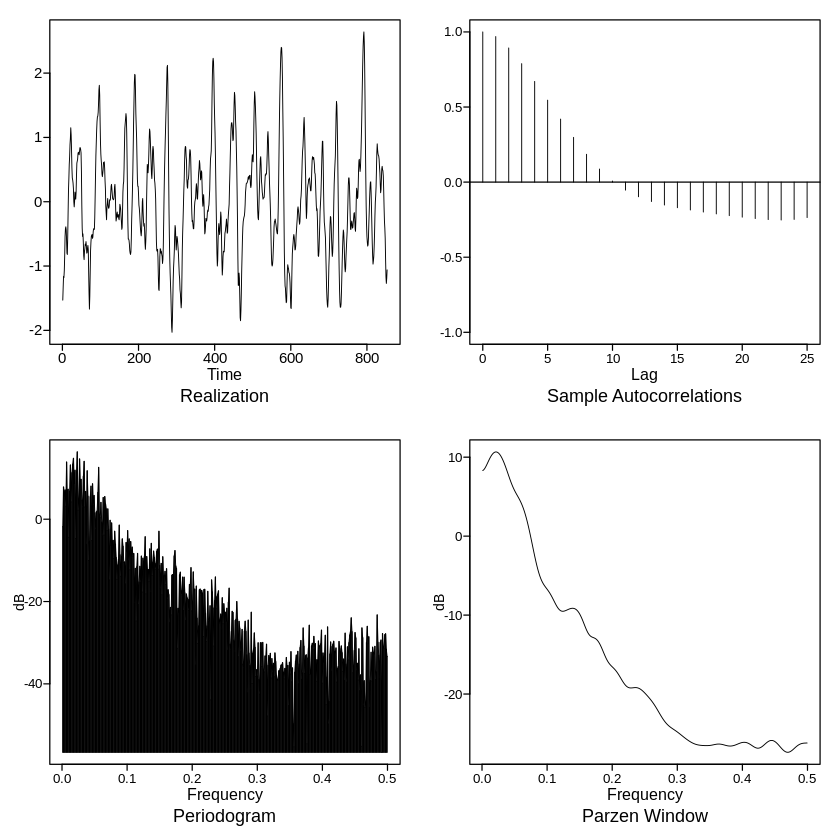

In [7]:
# For the periodogram and the parzen window plot
plotts.sample.wge(oni.ts)

From the plot, we can see that there is variability in the peaks of the realizations meaning there is variability in the magnitude and that this time series may be pseudo-periodic. The plot of the autocorrelation function demonstrates a peak at lag = 0, implying that the ONI of one year depends very strongly on the ONI of the previous/next year. There is a decay in correlation when the lags increase, and it starts to rise again around 2.0. 
   From the periodogram we can also observe that the freuquency peaks somewhere between 0 and 0.1, decreases until 0.3, and starts to increase again. The fact that there is a peak around f = 0 indicates that there is either a very long period or aperiodic behavior. 

In [ ]:
#Calculate the dominant frequenct
prdgram <- period.wge(oni.ts, dbcalc = TRUE, plot = FALSE)$pgram
domfreq_ONI <- period.wge(oni.ts, dbcalc = TRUE, plot = FALSE)$freq[which.max(prdgram)]
domfreq_ONI
#Calculate the period in years
(1/domfreq_ONI)/12

[1] 0.02344666

[1] 3.554167

The dominant frequency is 0.023. To examine the period in years, we calculate the inverse of this and divide by 12. The resulting value is 3.55 years.



### MEI Data

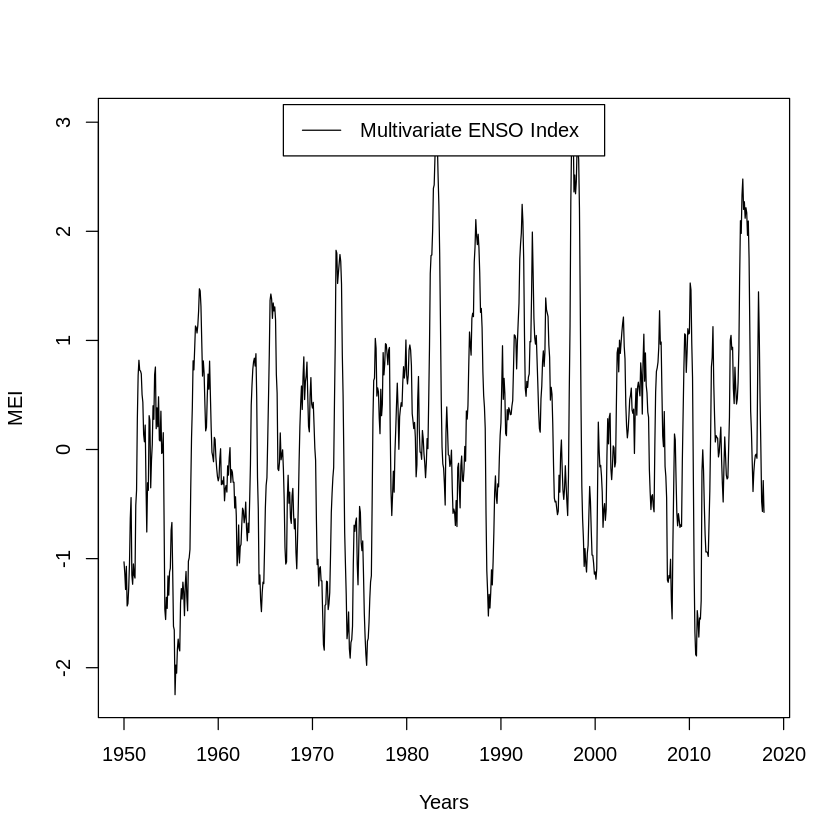

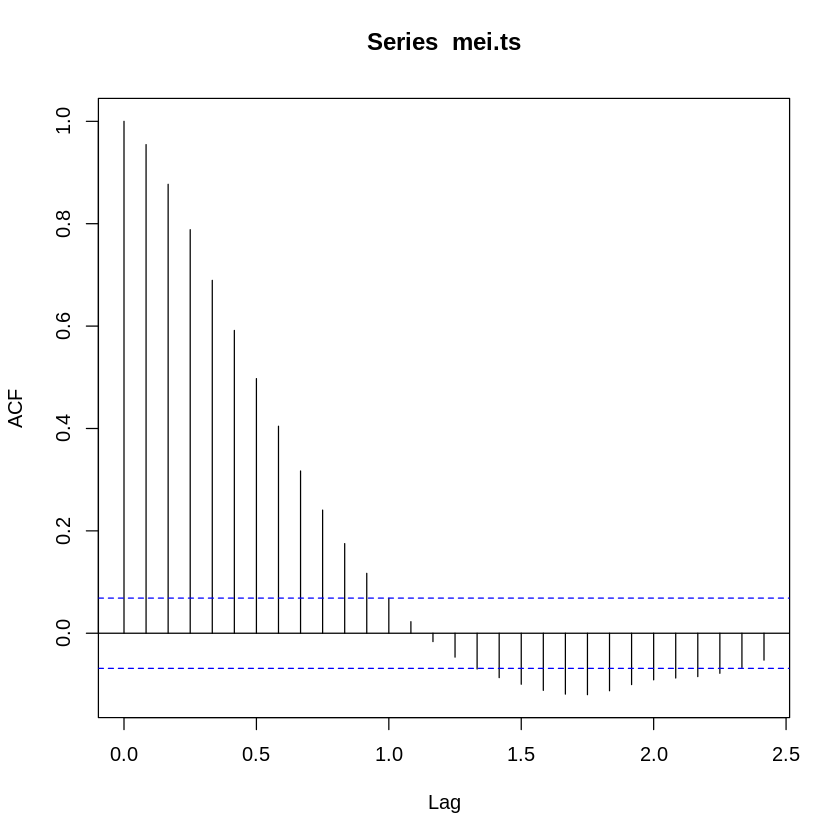

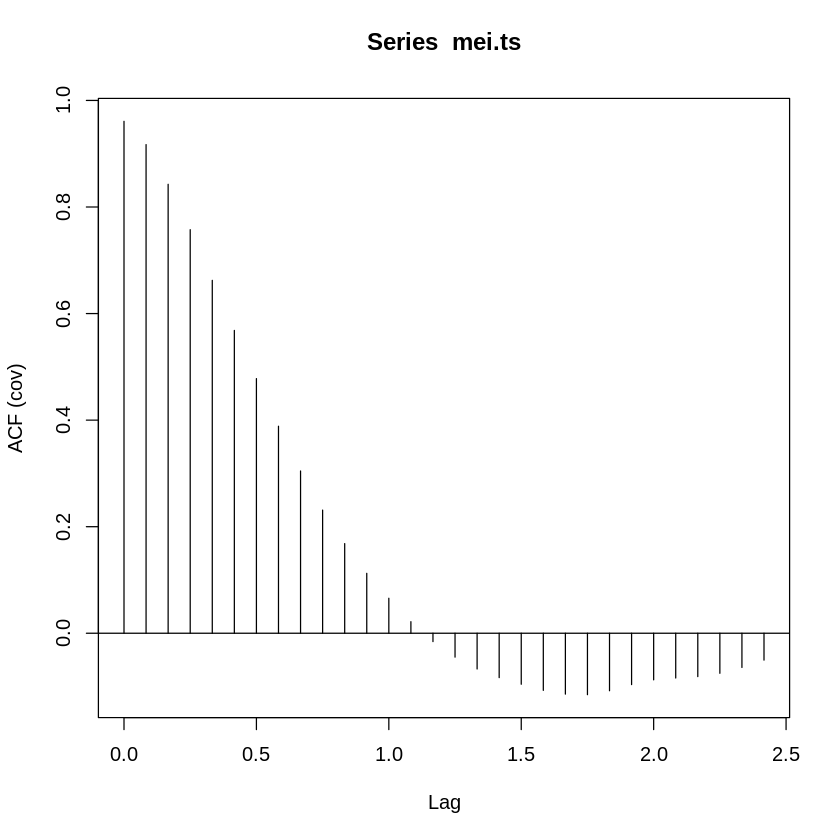

$autplt
 [1]  1.00000000  0.95452426  0.87699401  0.78832088  0.68934728  0.59152292
 [7]  0.49741247  0.40437996  0.31693908  0.24053720  0.17509545  0.11700807
[13]  0.06833394  0.02255892 -0.01630220 -0.04664058 -0.06978953 -0.08668282
[19] -0.09959381 -0.11155520 -0.11887022 -0.11999105 -0.11231434 -0.10030307
[25] -0.09098879 -0.08741753

$freq
  [1] 0.001225490 0.002450980 0.003676471 0.004901961 0.006127451 0.007352941
  [7] 0.008578431 0.009803922 0.011029412 0.012254902 0.013480392 0.014705882
 [13] 0.015931373 0.017156863 0.018382353 0.019607843 0.020833333 0.022058824
 [19] 0.023284314 0.024509804 0.025735294 0.026960784 0.028186275 0.029411765
 [25] 0.030637255 0.031862745 0.033088235 0.034313725 0.035539216 0.036764706
 [31] 0.037990196 0.039215686 0.040441176 0.041666667 0.042892157 0.044117647
 [37] 0.045343137 0.046568627 0.047794118 0.049019608 0.050245098 0.051470588
 [43] 0.052696078 0.053921569 0.055147059 0.056372549 0.057598039 0.058823529
 [49] 0.060049020 0.061274510 0.062500000 0.063725490 0.064950980 0.066176471
 [55] 0.067401961 0.068627451 0.069852941 0.071078431 0.072303922 0.073529412
 [61] 0.074754902 0.075980392 0.077205882 0.078431373 0.079656863 0.080882353
 [67] 0.082107843 0.083333333 0.084558824 0.085784314 0.087009804 0.088235294
 [73] 0.089460784 0.090686275 0.091911765 0.093137255 0.094362745 0.095588235
 [79] 0.096813725 0.098039216 0.099264706 0.100490196 0.101715686 0.102941176
 [85] 0.104166667 0.105392157 0.106617647 0.107843137 0.109068627 0.110294118
 [91] 0.111519608 0.112745098 0.113970588 0.115196078 0.116421569 0.117647059
 [97] 0.118872549 0.120098039 0.121323529 0.122549020 0.123774510 0.125000000
[103] 0.126225490 0.127450980 0.128676471 0.129901961 0.131127451 0.132352941
[109] 0.133578431 0.134803922 0.136029412 0.137254902 0.138480392 0.139705882
[115] 0.140931373 0.142156863 0.143382353 0.144607843 0.145833333 0.147058824
[121] 0.148284314 0.149509804 0.150735294 0.151960784 0.153186275 0.154411765
[127] 0.155637255 0.156862745 0.158088235 0.159313725 0.160539216 0.161764706
[133] 0.162990196 0.164215686 0.165441176 0.166666667 0.167892157 0.169117647
[139] 0.170343137 0.171568627 0.172794118 0.174019608 0.175245098 0.176470588
[145] 0.177696078 0.178921569 0.180147059 0.181372549 0.182598039 0.183823529
[151] 0.185049020 0.186274510 0.187500000 0.188725490 0.189950980 0.191176471
[157] 0.192401961 0.193627451 0.194852941 0.196078431 0.197303922 0.198529412
[163] 0.199754902 0.200980392 0.202205882 0.203431373 0.204656863 0.205882353
[169] 0.207107843 0.208333333 0.209558824 0.210784314 0.212009804 0.213235294
[175] 0.214460784 0.215686275 0.216911765 0.218137255 0.219362745 0.220588235
[181] 0.221813725 0.223039216 0.224264706 0.225490196 0.226715686 0.227941176
[187] 0.229166667 0.230392157 0.231617647 0.232843137 0.234068627 0.235294118
[193] 0.236519608 0.237745098 0.238970588 0.240196078 0.241421569 0.242647059
[199] 0.243872549 0.245098039 0.246323529 0.247549020 0.248774510 0.250000000
[205] 0.251225490 0.252450980 0.253676471 0.254901961 0.256127451 0.257352941
[211] 0.258578431 0.259803922 0.261029412 0.262254902 0.263480392 0.264705882
[217] 0.265931373 0.267156863 0.268382353 0.269607843 0.270833333 0.272058824
[223] 0.273284314 0.274509804 0.275735294 0.276960784 0.278186275 0.279411765
[229] 0.280637255 0.281862745 0.283088235 0.284313725 0.285539216 0.286764706
[235] 0.287990196 0.289215686 0.290441176 0.291666667 0.292892157 0.294117647
[241] 0.295343137 0.296568627 0.297794118 0.299019608 0.300245098 0.301470588
[247] 0.302696078 0.303921569 0.305147059 0.306372549 0.307598039 0.308823529
[253] 0.310049020 0.311274510 0.312500000 0.313725490 0.314950980 0.316176471
[259] 0.317401961 0.318627451 0.319852941 0.321078431 0.322303922 0.323529412
[265] 0.324754902 0.325980392 0.327205882 0.328431373 0.329656863 0.330882353
[271] 0.332107843 0.333333333 0.334558824 0.335784314 0.337009804 0.338235294
[277] 0.339460784 0.340686275 0.341911765 0.343137255 0.3443

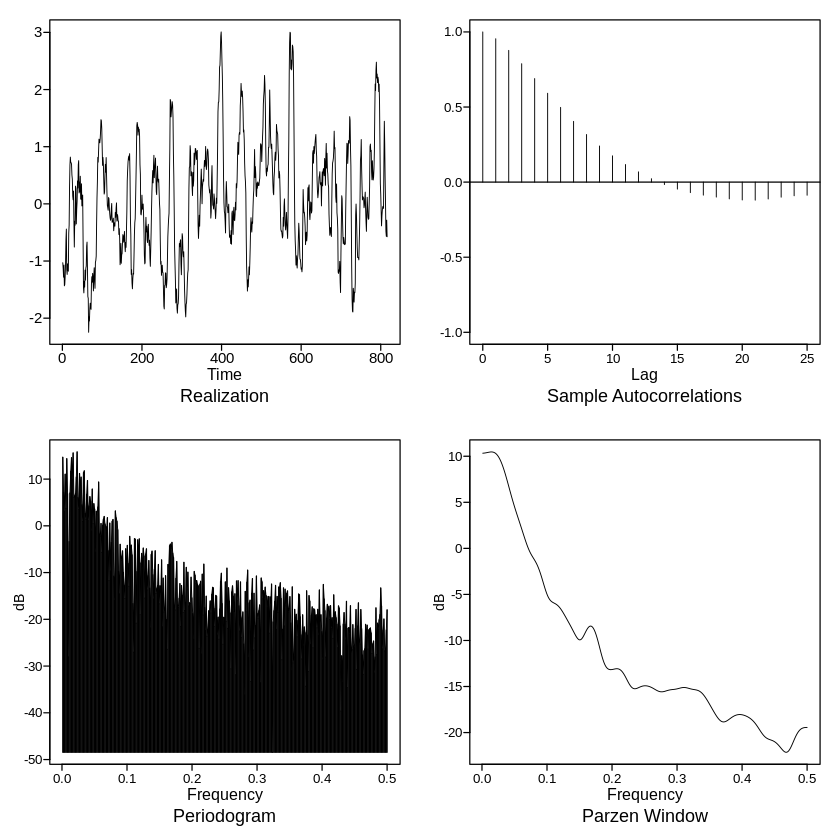

In [8]:
# Turn dataframe into a time series
mei.ts <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1950, 1), frequency = 12)
# Create a plot and add in the legned
plot(mei.ts, xlab = 'Years', ylab = 'MEI',)
legend("top", inset = 0.01, lty = 1, lwd = 1, legend = 'Multivariate ENSO Index')
# Create the plots
acf(mei.ts, type= 'correlation', plot = TRUE)
acf(mei.ts, type= 'covariance', plot = TRUE)
plotts.sample.wge(mei.ts)

The behavior of the MEi dataset is very similar to ONI, since they are both measuring the same thing (ENSO). There is variability in the peaks in that in constantly increases. The shapes of the periodogram and the plots of the autocorrelation/autocovariance functions are very similar to the previous ONI plots. The difference however is that there is not an increase in decibels by the end around the 0.3 mark.  

In [9]:
# Dominant frequency
mei.prdgram <- period.wge(mei.ts, dbcalc = TRUE, plot = FALSE)$pgram
domfreq_MEI <-period.wge(mei.ts, dbcalc = TRUE, plot = FALSE)$freq[which.max(mei.prdgram)]
# Period in years
domfreq_MEI
(1/domfreq_MEI)/12

[1] 0.02328431

[1] 3.578947

The dominant frequency is 0.025, and the period is around 3.57.

### PAD Data

In [10]:
# Turn the dataset into a time series
pad.ts <- ts(final_pad.df$final_pad.vect, start = c(1964, 1), frequency = 1)
# Plot the data
plot(pad.ts, main = 'PAD(per 1000) 1964-2017)', xlab = 'Year', ylab =  'PAD')
legend("top", inset = 0.01, lty = 1, lwd = 1, legend = 'People Affected by Disaster (per 1000)')
# Create plots for analysis
pad.ts.num <- as.numeric(pad.ts)
acf(pad.ts.num, type= 'correlation', plot = TRUE)
acf(pad.ts.num, type= 'covariance', plot = TRUE)
plotts.sample.wge(pad.ts.num)

ERROR: ignored

Looking at the plot of the realizations, there is again variantion in the peaks. There seems to be somewhat of a cycle every 15 to 20 years between the peaks. The periodogram shows that there is a peak around 0.2 and 0.4, meaning that there is a predominant period of about 5 and 2.5 years. The sample autrocorrelations graph peaks at 0 and immediatly dips down to a very small value, and there seems to be no other significant points.

In [11]:
# Calculate the dominant frequency
pad.prdgram <- period.wge(pad.ts.num, dbcalc = TRUE, plot = FALSE)$pgram
domfreq_PAD <-period.wge(pad.ts.num, dbcalc = TRUE, plot = FALSE)$freq[which.max(pad.prdgram)]
# Calculate eriod in years
domfreq_PAD
(1/domfreq_PAD)

ERROR: ignored

The dominant frequency is 0.2, and the period is 4.5 years. The smoothed parzen window plot shows another significant frequency at around 0.42, which equates to around 2.4 years. 

## Identifying El Ni&ntilde;o years in the dataset

According to the paper, the definition of an El nino event is when ONI > .5 for at least 5 consecutive overlapping 3-month periods during July-June.

In [12]:
# Subset the dataset to match the time frame 
oni.sub <- oni.df[which(oni.df$YR < 2018 & oni.df$YR > 1963),]
# Create a list of El Nino years
oni.sub$event <- oni.sub$ANOM > 0.5
oni.sub$ovrlap <- sequence(rle(as.character(oni.sub$event))$lengths)
nino_years <- oni.sub$YR[which(oni.sub$event == TRUE & oni.sub$ovrlap == 5)]
nino_years

[1] 1965 1969 1969 1972 1977 1978 1982 1987 1991 1995 1997 2002 2004 2007 2009
[16] 2015

From this list, we see that during the time period specified by the paper there were 15 distinct El Nino years. On average, El Nino events seem to happen around every 3 or 4 years.

## Another Time Series Dataset


The time series I will be looking at is the leaf and bloom dates dataset provided by the EPA. This time series looks at the how leaf and bloom dates of honeysuckles and lilacs deviate from the average between 1981 to 2010.  

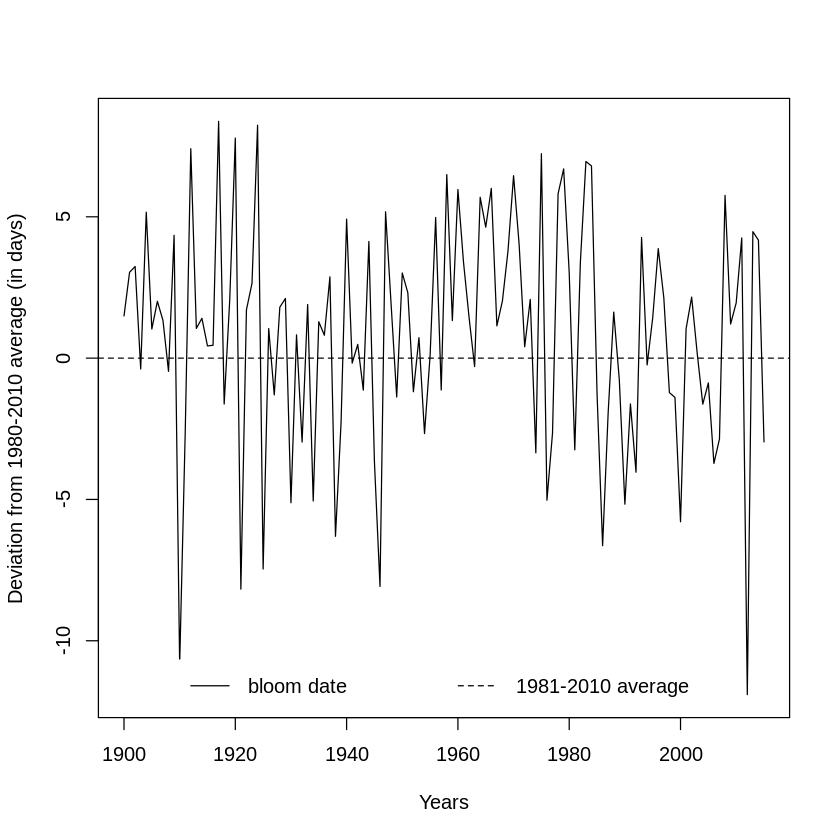

$autplt
 [1]  1.00000000 -0.08029021 -0.10025556  0.04930783  0.08716850  0.16901265
 [7] -0.05269703 -0.03610544  0.05298750  0.08153028 -0.10994412  0.11487462
[13]  0.01618523  0.10147238  0.05358493  0.03970459 -0.03674450 -0.01394365
[19]  0.03851501 -0.06983762  0.06644821 -0.12962181 -0.07620075 -0.01727135
[25]  0.04067792 -0.03706582

$freq
 [1] 0.00862069 0.01724138 0.02586207 0.03448276 0.04310345 0.05172414
 [7] 0.06034483 0.06896552 0.07758621 0.08620690 0.09482759 0.10344828
[13] 0.11206897 0.12068966 0.12931034 0.13793103 0.14655172 0.15517241
[19] 0.16379310 0.17241379 0.18103448 0.18965517 0.19827586 0.20689655
[25] 0.21551724 0.22413793 0.23275862 0.24137931 0.25000000 0.25862069
[31] 0.26724138 0.27586207 0.28448276 0.29310345 0.30172414 0.31034483
[37] 0.31896552 0.32758621 0.33620690 0.34482759 0.35344828 0.36206897
[43] 0.37068966 0.37931034 0.38793103 0.39655172 0.40517241 0.41379310
[49] 0.42241379 0.43103448 0.43965517 0.44827586 0.45689655 0.46551724
[55] 0.47413793 0.48275862 0.49137931 0.50000000

$db
 [1]  -0.604510527   5.747958244  -7.865763606 -29.575495479  -7.726783201
 [6]  -0.016038178  -2.289569245  -4.668938019   1.678939971   0.374714364
[11]  -7.126134945  -9.926467821  -3.710047591 -10.540609942  -5.218341699
[16]  -0.843648426  -2.885910403   0.111743933   2.540043470  -5.238194056
[21]  -7.517840084  -3.441903470   3.405946516   0.320794773   3.214095332
[26]   2.628451181   2.596860955  -8.795840921   3.005148618   4.928090172
[31]  -1.714879174  -3.254803155   4.134207660  -2.639189659  -8.339199369
[36]  -0.926376556  -5.229455885  -1.440021401  -8.600547733   4.967446393
[41]  -0.212987557   5.327294429  -3.923782778  -8.311463336  -6.383733968
[46]   2.668746358   0.191040308   1.359091776   0.005379093  -3.692499435
[51]  -2.113388427   6.300006432  -3.152626298  -1.206898145  -1.052062552
[56]  -3.769099736  -4.218101907 -12.437250693

$dbz
 [1]  0.53604140  0.25713004 -0.15505014 -0.62374493 -1.05965232 -1.39775151
 [7] -1.63383032 -1.82386523 -2.04266793 -2.33556329 -2.68655208 -3.00780953
[13] -3.16549922 -3.05812141 -2.69591386 -2.18701348 -1.65088260 -1.15766737
[19] -0.72117365 -0.31926851  0.07893696  0.48965930  0.90356950  1.29063967
[25]  1.61379797  1.84109101  1.95135399  1.93434799  1.78850421  1.51920686
[31]  1.13994725  0.67799272  0.18422127 -0.25895161 -0.54737617 -0.59796458
[37] -0.40359245 -0.04235340  0.37122344  0.73907428  1.00056679  1.13003602
[43]  1.12858753  1.01852050  0.84080165  0.65135381  0.50951695  0.45584488
[49]  0.48932720  0.56281381  0.60184380  0.53145506  0.29587468 -0.12910574
[55] -0.72166815 -1.38972554 -1.95019324 -2.17477056

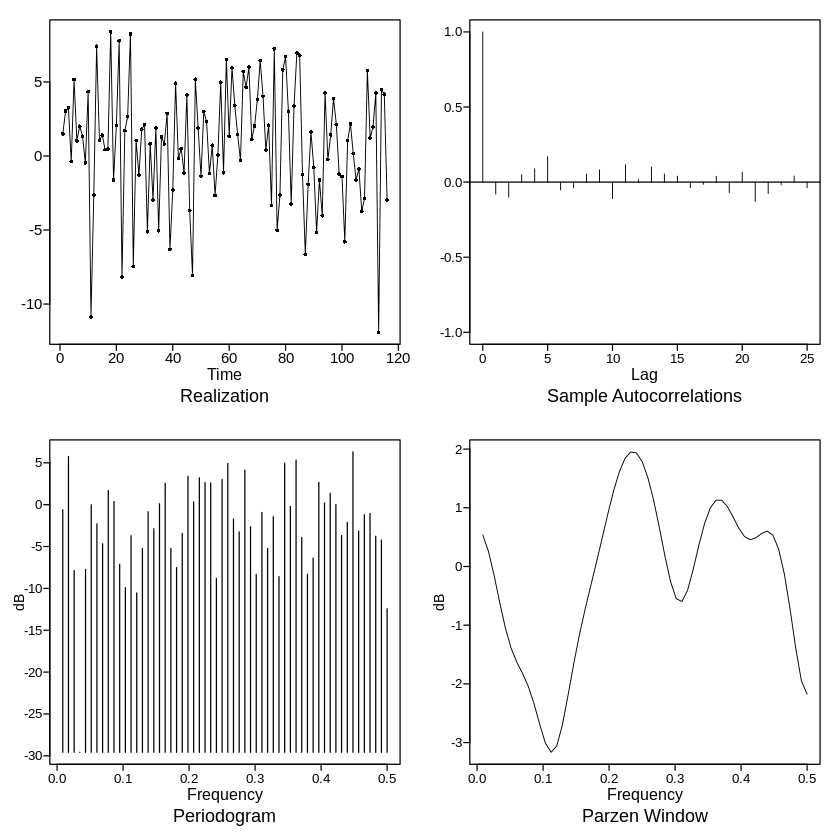

In [13]:
# Import dataet
bloom.url <- "https://www.epa.gov/sites/production/files/2016-08/leaf-bloom_fig-1.csv"
bloom.name <- tail(unlist(strsplit(bloom.url, "/")), n=1)
bloom.file <- paste("/tmp/", bloom.name, sep="")
download.file(bloom.url, bloom.file, method = 'auto')
# Create a time series for 
bloom.df.all <- read.csv(bloom.file, header=TRUE, skip=6) 
bloom.ts <- ts(bloom.df.all$Bloom.Mean, start = c(1900,1), frequency = 1)
# Create a plot and add the legend
plot(
  bloom.ts,
  xlab = 'Years',
  ylab = 'Deviation from 1980-2010 average (in days)',
  type = 'l',
)
abline(h = 0, lty = 2)
legend(
  "bottom", 
  inset=0.01, 
  lty=c(1,2), 
  lwd=c(1,1), 
  legend = c(
    'bloom date',
    '1981-2010 average'),
  bg="white",
  box.col="white",
  horiz=TRUE
)
# Create plots for analysis
plotts.sample.wge(bloom.ts)

The plot of the realizations do not display any visible seasonality or patterns. The autocorrelation function shows a peak at zero and a steep decline to a small value right after, and does not show any other significant points afterwards. This most likely signifies that this dataset is aperiodic or has a very long period. The periodogram does not display any significant points either. 

## Conclusion

In this lab, I was able to take data described in the study on the relationship between El Nino and people affected by disasters into R and analyze it. For the ONI and MEI data, it was only a matter of subsetting the data, creating the plot, and adding in the horizontal lines like the ones from the paper. For the PAD per 1000 plot, I had to take data from the EM-DAT and from Worldbank, integrate the two so that I can get the PAF in units per 1000. 
Next, I used tools we’ve used in class to further analyze the data. I used the `plotts.sample.wge()` function and the `acf()` function to examine the autocorrelation plot, autocovariance plot, and the periodogram. Both the functions were very useful and worked very well.The `plotts.sample.wge` function was particularly useful, since passing the time series into this single function outputted 4 different plots that were all important to my analysis. 
Then, I identified El Nino events with the specifications given in the study.
Finally, I imported a dataset I chose, the leaf and bloom dataset provided by the EPA and analyzed it with the same tools. 

There were quite a few challenges throughout the lab. The biggest challenge was calculating the PAD per 1000, since it involved taking two datasets and joining them together. All of the other datasets I could simply subset to find the target data, but the extra steps necessary in calculating the PAD per 1000 data was very difficult.

I was able to overcome these obstacles through some meeting with Professor Davis and looking up what I wanted to accomplish on Google. Stackoverflow had a lot of helpful information, and I eventually was able to get the code running the way I wanted it to. 



## References

Environmental Protection Agency. Climate change indicators: Leaf and bloom dates. 2016. Retrieved March 06, 2021, from https://www.epa.gov/climate-indicators/climate-change-indicators-leaf-and-bloom-dates

Lam, H. C. Y., Haines, A., McGregor, G., Chan, E. Y. Y., & Hajat, S.  Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle. 2019. International Journal of Environmental Research and Public Health, 16(17), 3146. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijerph16173146

